In [21]:
%matplotlib widget
import math
import numpy as np
import matplotlib.pyplot as plt

## From the basics
intuition on a derivative

In [22]:
def f(x):
  return 3*x**2 - 4*x + 5

In [23]:
f(3.0)

20.0

In [24]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [25]:
# Getting the derivative at f(x) for x = 3 | measuring the sensitivity of the change at x
h = 0.000000000001
x = 3.0
(f(x + h) - f(x)) / h

14.001244608152774

In [26]:
# A little more complex function
a = 2.0
b = -3.0
c = 10.0
d = a * b - c
print(d)

-16.0


In [27]:
# Getting the derivative of function d
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c

# bump a slightly by h to measure change
a += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


# Defining the Value class

In [32]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # the derivative of L w.r.t this Value
        self._backward = lambda: None # by default it is an empty function
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self): # print(self)
        return f"Value(data={self.data})"
        
    def __add__(self, other): # self + other
        other = other if isinstance(other, Value) else Value(other) # cast other to Value object if it isn't one
        out = Value(self.data + other.data, (self, other), '+')

        # Propogate the gradient
        def _backward():
            # The local derivative of an addition is 1.0
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other): # self * other
        other = other if isinstance(other, Value) else Value(other) # cast other to Value object if it isn't one
        out = Value(self.data * other.data, (self, other), '*')

        # Propogate the gradient
        def _backward():
            # The local derivative is (from chain rule) the other data value * out.grad
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __neg__(self): # -self
        return self * -1
        
    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return self - other

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
        
    def __pow__(self, other): # self ** other
        assert isinstance(other, (int, float)), "only supports int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * (self.data ** (other-1))) * out.grad
        out._backward = _backward

        return out
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # local derivative * global derivative (for chain rule) = e^x * globalDeriv.
        out._backward = _backward

        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
        
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
print('a + b = ', a + b)
print('a * b = ', a * b)

d = e + c; d.label = 'd'
print('a * b + c = ', d)

f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

a + b =  Value(data=-1.0)
a * b =  Value(data=-6.0)
a * b + c =  Value(data=4.0)


Value(data=-8.0)

## Digraph Visualization Code

In [33]:
from graphviz import Digraph

# Enumerates a graph to a set of nodes and edge connections
def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)

            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)

    # Creates value record nodes, op nodes, and links op node -> resulting value node
    for n in nodes:
        uid = str(id(n))
        
        # for any value in the graph, CREATE A 'RECORD' NODE for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, CREATE AN OP NODE
            dot.node(name = uid + n._op, label = n._op)
            # LINK OP NODE -> RESULT NODE
            dot.edge(uid + n._op, uid)

    # Links children value nodes to op nodes
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

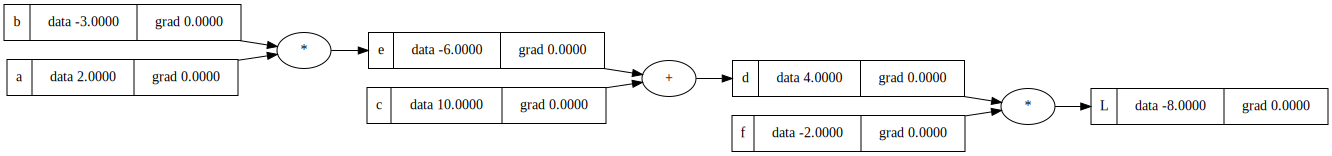

In [34]:
draw_dot(L)

## Manual Backpropogation
We want to now investigate backpropogation by taking the derivative of L (the "Loss function") w.r.t each weight (a, b, c, d, e, f) to examine how each weight affects the overall loss

In [35]:
""" MANUAL BACKPROPOGATION """
L.grad = 1.0 # the gradient of L to itself | essentially how is L sensitive to itself ... if we wiggle L by a small amount of h=0.001, how does it change; it is proportional hence 1

"""
DERIVING GRADIENTS FOR d AND f
L = d * f

What is the derivative of L w.r.t d?
dL
-- =? f
dd

dL
-- = ((f(x) + h) - f(x)) / h  = ((d + h)*f - d*f) / h = (d*f + h*f - d*f) / h = (h*f) / h = f
dd

Symmetrically, what is the derivative of L w.r.t f... = d
"""
f.grad = 4.0
d.grad = -2.0

"""
DERIVING GRADIENT for c and e
We know dL/dd, or how L is sensitive to a change in d. But how is L sensitive to c, if we wiggle c by a small amount h=0.001 how does that impact L through d?
If we know how c impacts d, and how d impacts L. We can chain these together to see how c impacts L.

d = c + e

What is dd / dc?
dd                         dd
-- = 1.0 and symmetrically -- = 1.0
dc                         de

Chain rule: If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 * 4 = 8 times as fast as the man.

WANT:
dL
-- = (dL / dd) * (dd / dc) = -2.0
dc

The (+) nodes local derivatives are just 1.0, so it essentially just flows the derivative backwards.

KNOW:
dL / dd = -2.0
dd / dc = 1.0
"""
c.grad = -2.0
e.grad = -2.0

"""
DERIVING GRADIENT for a and b
e = a * b

We want to know what is dL/da and dL/db.
From chain rule: dL / da = (dL / de) * (de / da)

dL / de = -2.0
de / da = b = -3.0

dL / da = -2.0 * -3.0

From chain rule: dL / db = (dL / de) * (de / db)
de / db = a = 2.0

dL / db = -2.0 * 2.0
"""
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

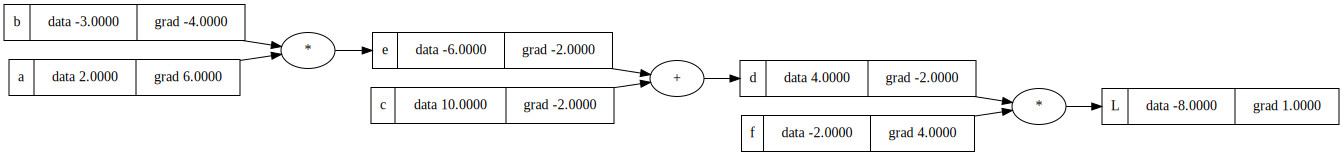

In [36]:
draw_dot(L)

In [37]:
# We can nudge the gradient of each weight up a little bit and expect L to increase positively
# a, b, c, f are leaf nodes while the others (e, d) are products of the operations
# We can think of a, b, c, f as weights of a network that we can tweak
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Simulate run of a forward pass
e = a * b
d = c + e
L = d * f
print(L.data)

-7.286496


In [38]:
def test():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1) / h)

test()

0.0


## tanh Activation Function

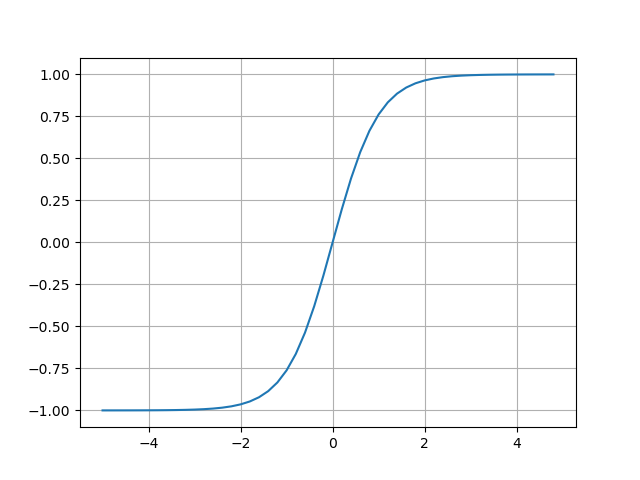

In [38]:
# tanh activation function
plt.clf();

plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)));
plt.grid();
plt.show();

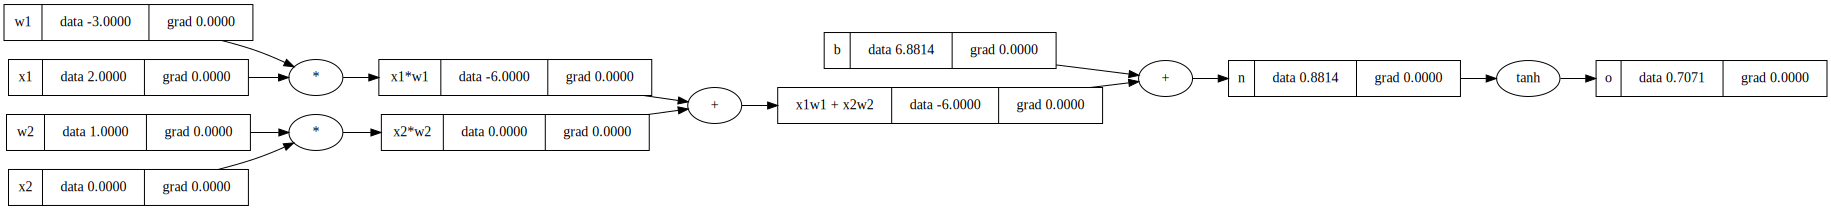

In [40]:
"""
2 inputs, 1 neuron, 1 output
x1 
   \
    n - o
   /
x2 
"""

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# Computing x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# Activation function on n
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [18]:
# Filling in gradients w/ manual backpropogation
o.grad = 1.0

"""
BACKPROP THROUGH TANH
To backprop through tanh, we need to know the local derivative of tanh

o = tanh(n)
what is do/dn?
From tanh wikipedia...
do/dn = 1 - tanh(n)**2 = 1 - o**2 = 1 - (0.7071)**2 = 0.5
"""
n.grad = 0.5

"""
BACKPROP FOR (x1w1 + x2w2) and b
Since the operator is a +, from the previous example we saw that a (+) is just a distributor of the gradient because the local derivative of an operation with (+) is just 1
and 1 * 0.5 is just 0.5.
"""
x1w1x2w2.grad = 0.5
b.grad = 0.5

"""
BACKPROP FOR (x2w2) and (x1w1)
The operator is a (+) so same thing
"""
x2w2.grad = 0.5
x1w1.grad = 0.5

# NOTE: Remember the derivative is telling us in every point in time along the expression that if we want the output of the neuron to increase, 
# the influence of these expressions are positive contributions

# The derivative always tells us the influence of some variable on the final output

"""
BACKPROP FOR x1, w1, x2, w2

x2w2 = x2 * w2 = 0.0 * 1.0
dx2w2/dx2 = 1.0
dx2w2/dw2 = 0.0

For x2:
do/dx2 = do/dx2w2 * dx2w2/dx2 = 0.5 * 1.0

For w2:
do/dw2 = do/dx2w2 * dx2w2/dw2 = 0.5 * 0.0

x1w1 = x1 * w1 = 2.0 * -3.0
dx1w1/dx1 = -3.0
dx1w1/dw1 = 2.0

For x1:
do/dx1 = do/dx1w1 * dx1w1/dx1 = 0.5 * -3.0
do/dw1 = do/dx1w1 * dx1w1/dw1 = 0.5 * 2.0
"""
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

In [19]:
# Implementing _backward() gradient to remove hand calculation
o.grad = 1.0 # Set the initial gradient
o._backward() # Call the backward on tanh
n._backward() # Call the backward on __add__
b._backward() # b has no backward since it is a leaf node
x1w1x2w2._backward() # Calls the backward on __add__
x2w2._backward() # Calls the backward on __mul__
x1w1._backward() # Calls the backward on __mul__

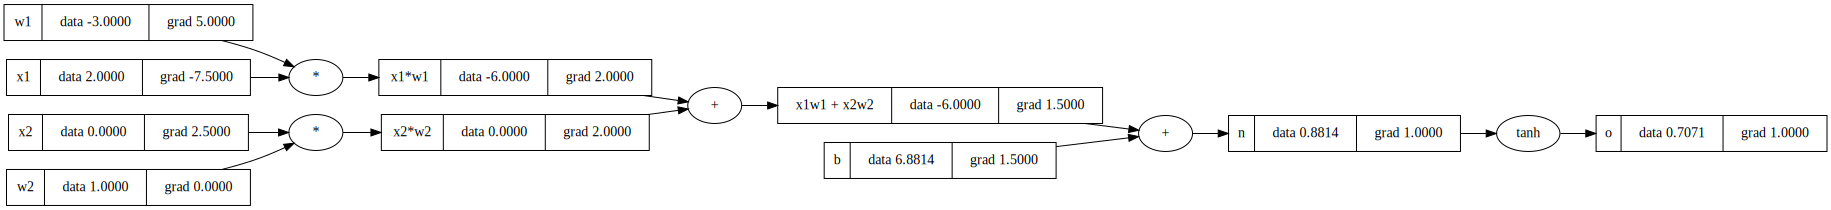

In [20]:
draw_dot(o)

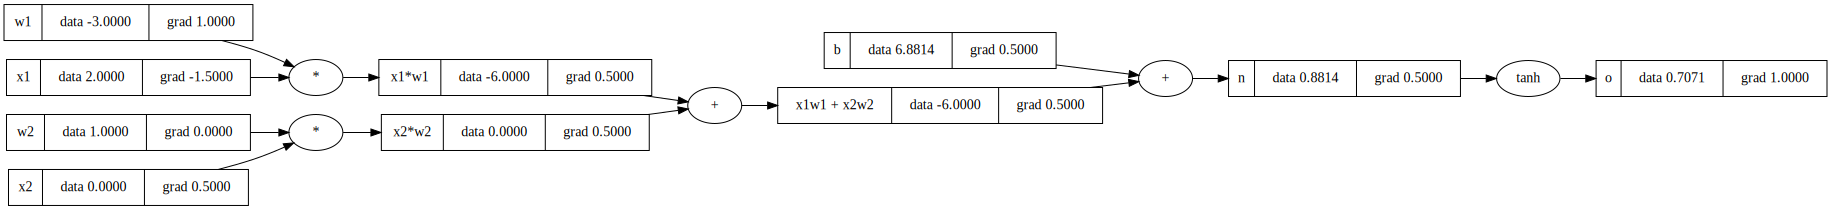

In [41]:
# Topological Sort to  layout the expression graph in a sorted order where children nodes precede the parent nodes to be able to call _backward() properly
o.backward()
draw_dot(o)

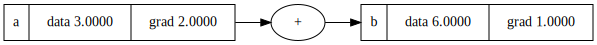

In [42]:
# Fixing bug where reusing a variable resets the gradient; use multivariate chain rule to accumulate the gradients
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

## Breaking up tanh + implementing more operations (rmul, neg, sub, truediv, exp)
After adding additional support for the above operations, we can split up tanh to the mathematical symbolic equivalent and it would still work

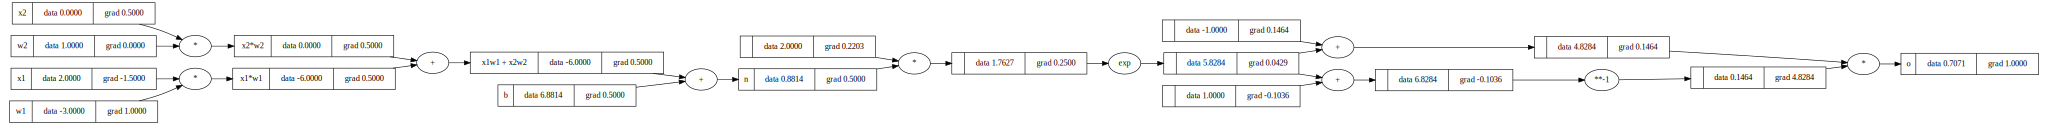

In [43]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# Computing x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# Activation function on n
# ----
# Wikipedia: tanh = e^2x - 1 /  e^2x + 1
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

## Doing the same things in PyTorch

In [44]:
import torch

# Define value objects
# Micrograd is a scalar valued engine; there are only scalar values like 2.0
# In Pytorch, everything is based on Tensors (n-dimensional arrays of scalars)
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w2', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w2 1.0000002567688737


## Building up a neural net
just a special class of mathematical expressions like what we've been doing

In [64]:
import random

# Defining one neuron
class Neuron:
    # nin: number of inputs
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] # a list of weights with an initial random num from -1 to 1 for nin inputs
        self.b = Value(random.uniform(-1, 1))                       # a bias with an initial random num from -1 to 1 that controls the overall trigger happiness of the neuron

    # x = [2.0, 3.0]
    # n = Neuron(2) - 2 dim. input
    # n(x) invokes __call__
    def __call__(self, x):
        # w * x + b - want to dot product the weights and input data and add the bias
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh() # pass activation through a non-linearity
        return out

    def parameters(self):
        return self.w + [self.b]

# Defining a layer of neurons
class Layer:
    # nin: number of input data
    # nout: number of neurons in a single layer
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)

        return params
        
# Defining multiple layers of neurons
class MLP:
    # nin: number of input data
    # nouts: list describing # of neurons for each layer
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

Value(data=0.7955756950331959)

In [129]:
# Instantiate our MLP
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.001711158955743627)

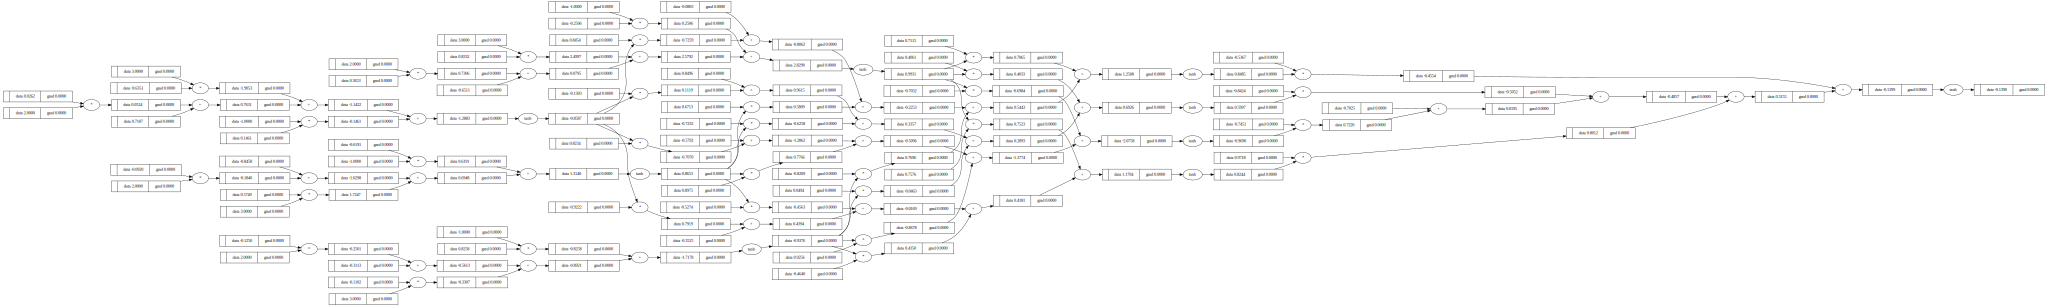

In [52]:
draw_dot(n(x))

In [65]:
n.parameters() # all the weights and biases in the MLP

[Value(data=0.4719719068821875),
 Value(data=-0.42690179618540736),
 Value(data=-0.47763520380629165),
 Value(data=0.8217649930953492),
 Value(data=0.8941616562045089),
 Value(data=0.0128034983187304),
 Value(data=-0.49736630931396353),
 Value(data=-0.4424348202520314),
 Value(data=0.6713200237631023),
 Value(data=0.604913994709146),
 Value(data=-0.8508414280658041),
 Value(data=0.46428335140183696),
 Value(data=0.46562862976427355),
 Value(data=-0.7963747998853872),
 Value(data=-0.8540730058983694),
 Value(data=0.28667703301006053),
 Value(data=-0.20906833079378306),
 Value(data=-0.7910008926129191),
 Value(data=-0.9797637972788982),
 Value(data=-0.240662360182893),
 Value(data=-0.7560267478940421),
 Value(data=0.41967089542067004),
 Value(data=0.24960037528451795),
 Value(data=0.04884501561951371),
 Value(data=0.23264671885270705),
 Value(data=-0.5602530779444825),
 Value(data=-0.5154837455932846),
 Value(data=0.1563793975110921),
 Value(data=-0.9003588757760044),
 Value(data=0.43993

## Creating an example dataset

In [130]:
# SIMPLE BINARY CLASSIFIER NEURAL NET
# 4 examples / sets of data to pass into our neural net
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# 4 true targets
ys = [1.0, -1.0, -1.0, 1.0]

# Getting the current predictions from our neural net on its current weights and biases
ypred = [n(x) for x in xs]
ypred

[Value(data=0.001711158955743627),
 Value(data=0.5582193233849064),
 Value(data=0.3486211281131615),
 Value(data=0.23207204308105828)]

## The Loss
a single number that measures the total performance of the neural net
|
MSE Loss: take the sum of squared differences between the predicted and ground truths

In [67]:
loss = sum([(yt - yp) ** 2 for yt, yp in zip(ys, ypred)])
loss

Value(data=6.458250875581715)

In [68]:
loss.backward() # calculate the backward propogation w.r.t this loss

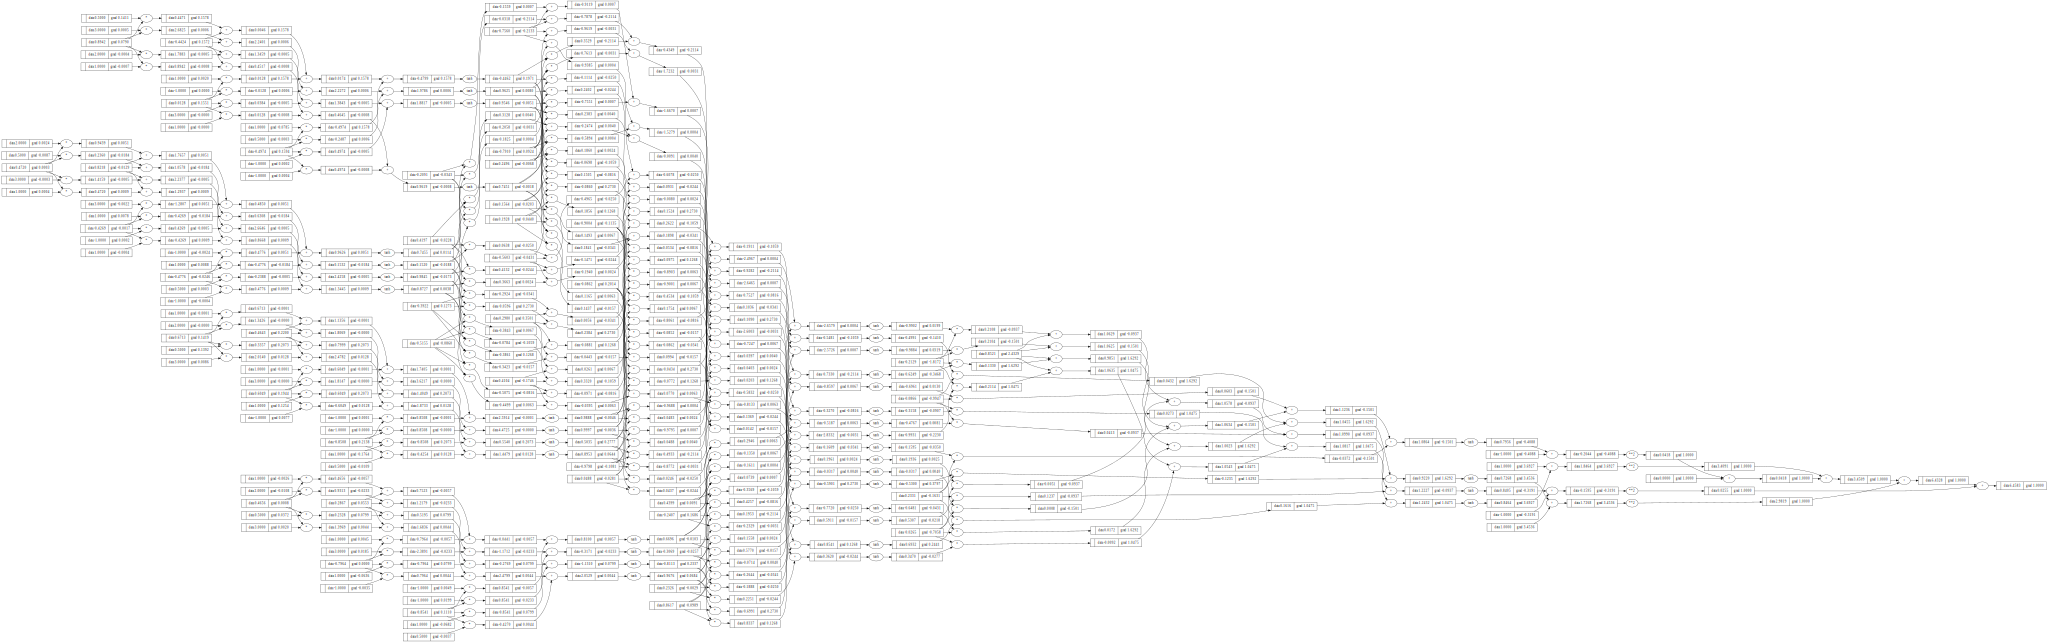

In [69]:
draw_dot(loss)

In [71]:
n.layers[0].neurons[0].w[0].grad # 0.000290, the derivative of this neuron is positive, we can see that nudging this weight up will decrease our total loss

0.00029021021627867656

In [72]:
n.layers[0].neurons[0].w[0].data

0.4719719068821875

## Gradient Descent

In [73]:
# Gradient Descent: we are modifiying the data values in a small step size in the direction of the gradient to minimize the loss
# We can think of the gradient vector as pointing in the direction if increasing loss, so by taking a small step size in the opposite direction for that neuron we can decrease loss instead
for p in n.parameters():
    p.data += -0.01 * p.grad

In [75]:
n.layers[0].neurons[0].w[0].data

0.4719690047800247

In [76]:
## Recalculating loss after updating values with gradient descent
ypred = [n(x) for x in xs]
loss = sum([(yt - yp) ** 2 for yt, yp in zip(ys, ypred)])
loss

Value(data=6.342566186278557)

## The Training Loop: Iterate this process

In [162]:
# Instantiate the MLP model
n = MLP(3, [4, 4, 1])

# Instantiate our training data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# 4 true targets
ys = [1.0, -1.0, -1.0, 1.0]

In [163]:
# THE ENTIRE GRADIENT DESCENT ALGORITHM 

for k in range(100):
    # Forward Pass: Calculate the loss
    ypred = [n(x) for x in xs]
    loss = sum([(yt - yp) ** 2 for yt, yp in zip(ys, ypred)])

    # Backward Pass: Update gradients- backprop on the loss to calculate the gradients of the weights and biases
    ## Zero-grad our gradients from the previous backprop iteration
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Update: nudge the weights and biases against the gradients
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 1.5531354397179256
1 1.1019240186027748
2 0.7187740168952765
3 0.456933079266487
4 0.3054919163857942
5 0.21887378650223122
6 0.1662679499435698
7 0.1321476314662732
8 0.10869738467938905
9 0.09179560510190439
10 0.07913613829448705
11 0.06935338193045808
12 0.06159728605080236
13 0.055315509597808295
14 0.05013572639979426
15 0.04579891746736995
16 0.04211991758910971
17 0.0389631887998419
18 0.03622744374351597
19 0.033835596627565814
20 0.031728023340381654
21 0.029857935273618273
22 0.02818813750511765
23 0.0266887143297111
24 0.02533534877627299
25 0.024108083633369293
26 0.022990395157376373
27 0.021968491657244783
28 0.02103077610358734
29 0.0201674299387227
30 0.019370087523293535
31 0.018631579118064345
32 0.017945726224573137
33 0.017307177310993363
34 0.016711274966977288
35 0.016153947722352454
36 0.015631621372565727
37 0.015141145845649802
38 0.01467973453719214
39 0.01424491371279092
40 0.01383448008963565
41 0.013446465101649166
42 0.013079104656112714
43 0.0127308134

In [164]:
ypred

[Value(data=0.976600596145286),
 Value(data=-0.9796173765636651),
 Value(data=-0.9576280022745194),
 Value(data=0.9522233950050492)]